# Football Ratings — Exploratory Data Analysis (Portfolio)

This notebook demonstrates practical data analysis skills with a football match ratings dataset: loading and validating data, computing robust aggregations (with de-duplication where needed), and communicating findings through clear visualizations.

**Data source (CSV):** `data_football_ratings.csv`  
**Core techniques:** pandas (filtering, groupby, nunique), matplotlib (visualization), basic data-quality checks.


## 1) Setup and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv(r"/mnt/data/data_football_ratings.csv")
df.head()

,original_rating,game_duration,competition,team,date,match,player,goals,rcards,minutesPlayed
0,5.926450,95,Premier League 2017/18,Juventus,2017-12-04,Liverpool vs Everton (PL-1),Gianluigi Buffon,0,0,79
1,6.859789,95,Premier League 2017/18,Bayern Munich,2017-12-04,Liverpool vs Everton (PL-1),Robert Lewandowski,1,0,72
2,6.952066,95,Premier League 2017/18,Manchester City,2017-12-04,Liverpool vs Everton (PL-1),Sergio Aguero,0,1,67
3,7.196776,95,Premier League 2017/18,West Ham,2017-12-04,Liverpool vs Everton (PL-1),Aaron Cresswell,0,0,52
4,1.000000,95,Premier League 2017/18,Chelsea,2017-12-04,Liverpool vs Everton (PL-1),Eden Hazard,0,0,0


## 2) Dataset quick check

In [2]:
# Schema + basic null check
df.info()

# Missing values by column (top-level quality signal)
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053 entries, 0 to 2052
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   original_rating  2053 non-null   float64
 1   game_duration    2053 non-null   int64  
 2   competition      2053 non-null   object 
 3   team             2053 non-null   object 
 4   date             2053 non-null   object 
 5   match            2053 non-null   object 
 6   player           2053 non-null   object 
 7   goals            2053 non-null   int64  
 8   rcards           2053 non-null   int64  
 9   minutesPlayed    2053 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 160.5+ KB


original_rating    0
game_duration      0
competition        0
team               0
date               0
match              0
player             0
goals              0
rcards             0
minutesPlayed      0
dtype: int64

## 3) Summary statistics for the rating signal

In [3]:
# Central tendency + dispersion for original_rating
mean_rating = df["original_rating"].mean()
median_rating = df["original_rating"].median()
std_rating = df["original_rating"].std()

mean_rating, median_rating, std_rating

(6.19730638530711, 6.658746158885562, 2.0689967898254964)

### Rating distribution
A quick view of the distribution, including the presence of `1.0` values often used as a special code (e.g., not evaluated).

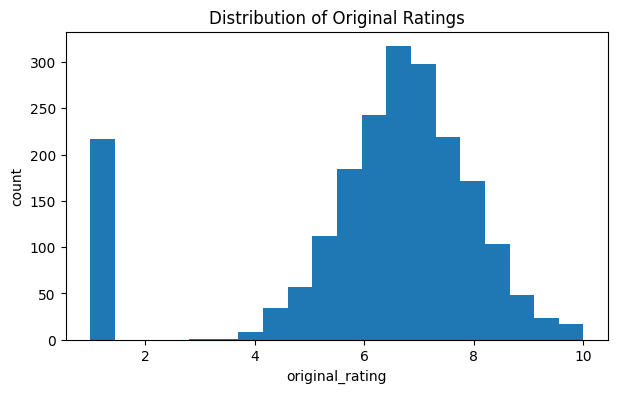

In [4]:
plt.figure(figsize=(7,4))
plt.hist(df["original_rating"], bins=20)
plt.title("Distribution of Original Ratings")
plt.xlabel("original_rating")
plt.ylabel("count")
plt.show()

## 4) Match-level metrics (handling player-level rows)
The dataset contains multiple rows per match (one per player). For match-level questions, we use **unique matches**.

In [5]:
# How many unique matches exist?
n_matches = df["match"].nunique()
n_rows = len(df)

n_rows, n_matches

(2053, 179)

### Extra-time matches (120 minutes)
Count unique matches where `game_duration == 120`.

In [6]:
n_120 = int(df.loc[df["game_duration"] == 120, "match"].nunique())
n_120

31

## 5) Tournament slice example — World Cup 2018 (Croatia)
Count how many unique matches Croatia played in World Cup 2018.

In [7]:
croatia_wc2018_matches = int(
    df.loc[(df["competition"] == "World Cup 2018") & (df["team"] == "Croatia"), "match"].nunique()
)
croatia_wc2018_matches

16

## 6) Player focus — Robert Lewandowski goals (club vs national team)
We group goals into club (**Bayern Munich**) vs national team (**Poland**) and visualize the split.

In [8]:
lew = df[df["player"] == "Robert Lewandowski"].copy()

# Avoid double-counting if multiple rows exist for the same match/team
lew_unique = lew.drop_duplicates(subset=["match","team"])

goals_bayern = int(lew_unique.loc[lew_unique["team"] == "Bayern Munich", "goals"].sum())
goals_poland = int(lew_unique.loc[lew_unique["team"] == "Poland", "goals"].sum())

total = goals_bayern + goals_poland
share_bayern = 0 if total == 0 else round(goals_bayern / total, 2)
share_poland = 0 if total == 0 else round(goals_poland / total, 2)

goals_bayern, goals_poland, share_bayern, share_poland

(30, 12, 0.71, 0.29)

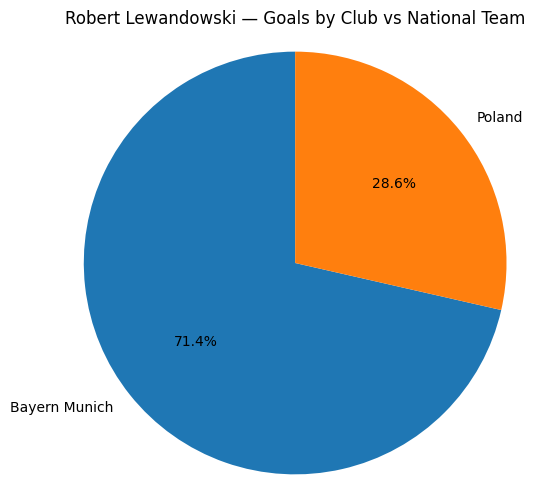

In [9]:
plt.figure(figsize=(6,6))
plt.pie([goals_bayern, goals_poland], labels=["Bayern Munich", "Poland"], autopct="%1.1f%%", startangle=90)
plt.title("Robert Lewandowski — Goals by Club vs National Team")
plt.axis("equal")
plt.show()

## 7) Discipline indicator — red cards in Euro 2016
We count unique matches in Euro 2016 where at least one red card was recorded.

In [10]:
euro_redcard_matches = int(df.loc[(df["competition"] == "Euro 2016") & (df["rcards"] == 1), "match"].nunique())
euro_redcard_matches

19

## 8) Evaluations coverage by player
A player is treated as **not evaluated** when `original_rating == 1` and `minutesPlayed < 20`.
We count evaluated matches per player (unique matches), and show the top of the alphabet (for reproducible indexing).

In [11]:
evaluated = df[~((df["original_rating"] == 1) & (df["minutesPlayed"] < 20))].copy()

matches_evaluated = (evaluated.groupby("player")["match"]
                     .nunique()
                     .sort_index())

df_player_coverage = matches_evaluated.to_frame("matches_evaluated")
df_player_coverage.head(10)

,matches_evaluated
player,
Aaron Cresswell,78
Antoine Griezmann,90
Cristiano Ronaldo,89
Eden Hazard,87
Gianluigi Buffon,88
Harry Kane,87
Karim Benzema,93
Kevin De Bruyne,71
Kylian Mbappe,83


## 9) Additional visuals (portfolio)
These plots add signal about rating behavior, minutes played, and relationships between variables.

### 9.1 Average rating by competition

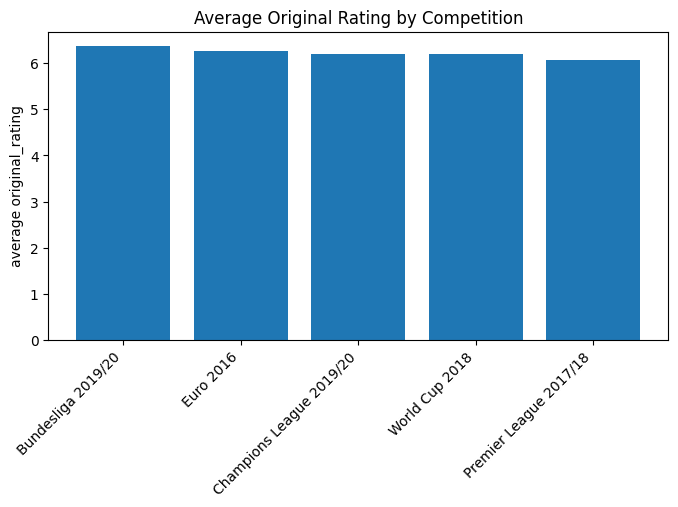

competition
Bundesliga 2019/20          6.366047
Euro 2016                   6.259263
Champions League 2019/20    6.209792
World Cup 2018              6.200457
Premier League 2017/18      6.064022
Name: original_rating, dtype: float64

In [12]:
avg_by_comp = df.groupby("competition")["original_rating"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(avg_by_comp.index, avg_by_comp.values)
plt.title("Average Original Rating by Competition")
plt.xticks(rotation=45, ha="right")
plt.ylabel("average original_rating")
plt.show()

avg_by_comp

### 9.2 Minutes played vs rating (scatter)
This helps validate whether low minutes correlate with lower / special-coded ratings.

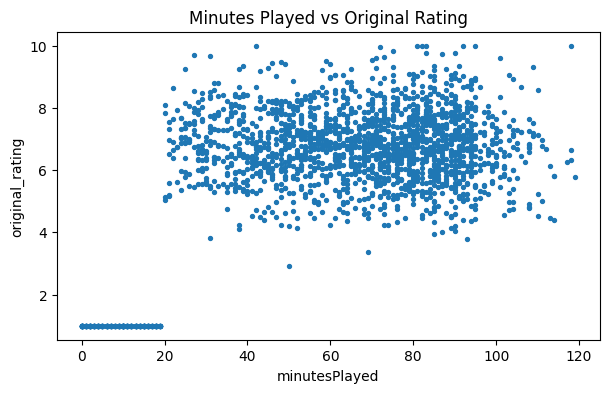

In [13]:
plt.figure(figsize=(7,4))
plt.scatter(df["minutesPlayed"], df["original_rating"], s=8)
plt.title("Minutes Played vs Original Rating")
plt.xlabel("minutesPlayed")
plt.ylabel("original_rating")
plt.show()

### 9.3 Correlation matrix (numeric columns)
A quick correlation check across numeric fields.

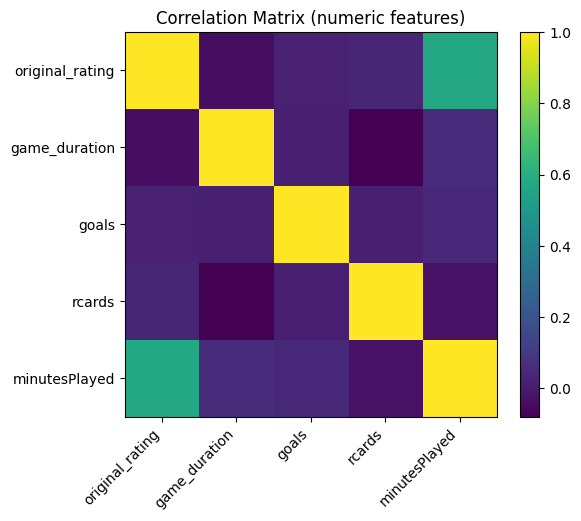

,original_rating,game_duration,goals,rcards,minutesPlayed
original_rating,1.000000,-0.038047,0.018103,0.037147,0.571322
game_duration,-0.038047,1.000000,0.013169,-0.079789,0.055649
goals,0.018103,0.013169,1.000000,0.014714,0.039423
rcards,0.037147,-0.079789,0.014714,1.000000,-0.028245
minutesPlayed,0.571322,0.055649,0.039423,-0.028245,1.000000


In [14]:
num_cols = ["original_rating", "game_duration", "goals", "rcards", "minutesPlayed"]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
plt.imshow(corr.values, aspect="auto")
plt.title("Correlation Matrix (numeric features)")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.show()

corr

## 10) Notes for reviewers
- Match-level results use `nunique(match)` to avoid double counting due to player-level granularity.
- The notebook is designed to be reproducible and readable, emphasizing clarity in transformations and assumptions.